### **資料前處理**

- 對數轉換：
    - 處理偏態分佈：流量數據（如頁面瀏覽量和訪客數）通常呈右偏態（少數值很大，多數值較小）。
    - 對數轉換使其分佈更接近正態分佈，便於線性迴歸假設的滿足。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

# font
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定中文字型 - 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號'-'顯示為方塊的問題


In [3]:
# read CSV / TSV
file = pd.read_csv("Top_1000_sites.tsv", sep='\t')

file['PageViews'] = file["Page_Views"].astype(float)
file['UniqueVisitors'] = file['Unique_Visitors_(users)'].astype(float)

#  PageViews and UniqueVisitors -> log()
file['log_PageViews'] = np.log(file['PageViews'])
file['log_UniqueVisitors'] = np.log(file['UniqueVisitors'])

pageViews = file['log_PageViews']
uniqueVisitors = file['log_UniqueVisitors']


### **僅考慮 log_UniqueVisitors 以及 log_PageViews**

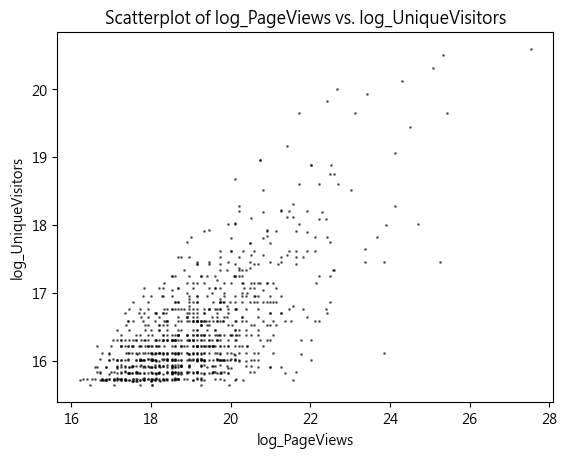

In [4]:
# Scatterplot of log_PageViews vs. log_UniqueVisitors
plt.scatter(pageViews, uniqueVisitors,alpha=0.5, s=1 ,c='black')
plt.xlabel('log_PageViews')
plt.ylabel('log_UniqueVisitors')
plt.title('Scatterplot of log_PageViews vs. log_UniqueVisitors')
plt.show()


#### **面向：解釋訓練數據的關係 - Statsmodels (OLS)**

In [5]:
X = sm.add_constant(uniqueVisitors)  # 添加 constant 截距項
y = pageViews
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          log_PageViews   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     855.6
Date:                Wed, 02 Apr 2025   Prob (F-statistic):          2.46e-136
Time:                        02:29:09   Log-Likelihood:                -1498.3
No. Observations:                1000   AIC:                             3001.
Df Residuals:                     998   BIC:                             3010.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.8344      0

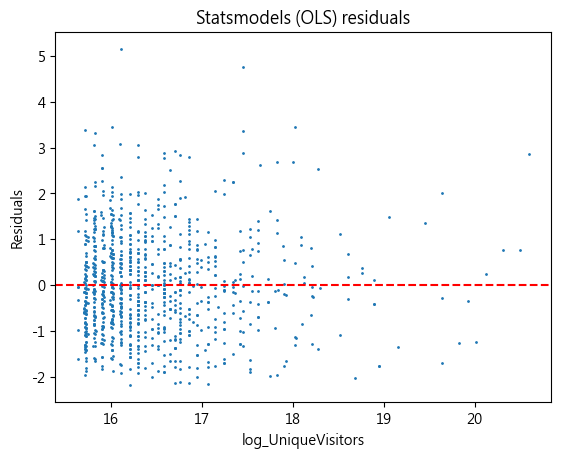

In [6]:
# residuals

residuals = model.resid
plt.scatter(uniqueVisitors, residuals,s=1)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('log_UniqueVisitors')
plt.ylabel('Residuals')
plt.title('Statsmodels (OLS) residuals')
plt.show()


#### **面向：預測新數據的性能 - Scikit-learn (交叉驗證)**

In [11]:
X = file[['log_UniqueVisitors']]
y = pageViews

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2023)

model = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('regressor', LinearRegression())
])

# evaluation
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("y_test mean:", y_test.mean())
print("y_test std:", y_test.std())
print("\n")

r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R^2 scores:", r2_scores)
print("Mean R^2:", r2_scores.mean())
print("Std R^2:", r2_scores.std())

mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)
print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Std RMSE:", rmse_scores.std())


y_test mean: 19.215886109020484
y_test std: 1.4266398362900836


Cross-validated R^2 scores: [ 0.4470364   0.01661505  0.00389034 -0.00640382  0.02897507]
Mean R^2: 0.09802260974702322
Std R^2: 0.17491206047459887
Cross-validated RMSE scores: [1.22131502 1.09230945 1.05065936 1.03487517 1.00948769]
Mean RMSE: 1.0817293371333805
Std RMSE: 0.07480055369390878


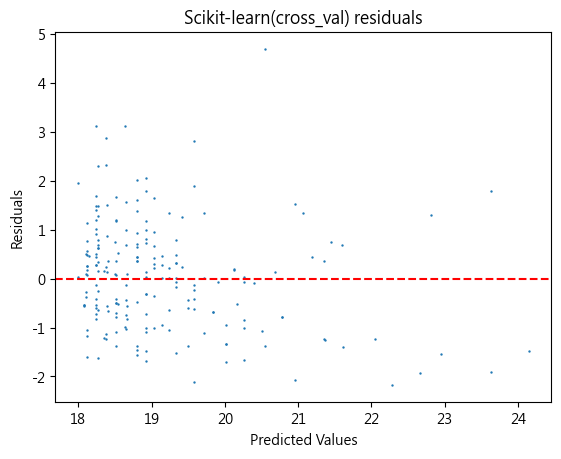

In [12]:
# residuals

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

residuals = y_test - y_pred
plt.scatter(y_pred, residuals, s=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title('Scikit-learn(cross_val) residuals')
plt.show()


#### **小結論**

- **預測用途**：參照 Scikit-learn 的 \(R^2 = 0.098\)，當前模型不合格。
- **解釋用途**：參照 Statsmodels 的 \(R^2 = 0.462\)，`log_UniqueVisitors` 特徵有價值。

- **預測面 - 參照 Scikit-learn 交叉驗證結果：**
    - \(R^2 = 0.098\) 更真實地反映模型在未見數據上的表現。
    - 目前結果顯示預測能力差（\(R^2\) 低，RMSE 高），意味著單純用 `log_UniqueVisitors` 和線性回歸不足以應用於實際預測，表明需要改進模型，例如增加特徵或使用非線性模型。

- **解釋面 - 參照 Statsmodels OLS 結果：**
    - \(R^2 = 0.462\) 和顯著的係數（1.336）顯示 `log_UniqueVisitors` 與 `log_PageViews` 有較強的統計關係。
    - OLS 的 \(R^2\) 和 p 值是統計分析的標準，特別是用於理解因果關係或特徵重要性。

| 面向           | Scikit-learn (交叉驗證)         | Statsmodels (OLS)           |
|-|-|-|
| **數據使用**   | 80% 訓練，20% 測試，5 次平均   | 100% 數據擬合              |
| **\(R^2\)**    | 0.098（泛化能力）             | 0.462（擬合能力）          |
| **穩定性**     | 波動大（Std = 0.175）         | 未評估                    |
| **目標**       | 預測新數據的性能              | 解釋訓練數據的關係         |
| **誤差評估**   | RMSE = 1.082                 | 未直接提供（可計算）       |

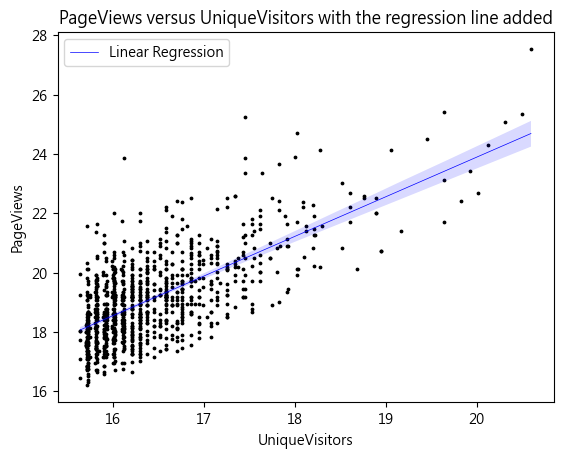

In [13]:
# PageViews versus UniqueVisitors with the regression line added
plt.scatter(uniqueVisitors, pageViews ,s=3 ,c='black')
sns.regplot(x= uniqueVisitors, y = pageViews, data=file, scatter=False, label='Linear Regression', line_kws={'color':'blue', 'linewidth':0.5})
plt.xlabel('UniqueVisitors')
plt.ylabel('PageViews')
plt.legend()
plt.title('PageViews versus UniqueVisitors with the regression line added')
plt.show()


### **將 HasAdvertising、InEnglish 納入變因考量**

Nan counts: 0
Advertising Status: No, Data Size: 162
Advertising Status: Yes, Data Size: 838


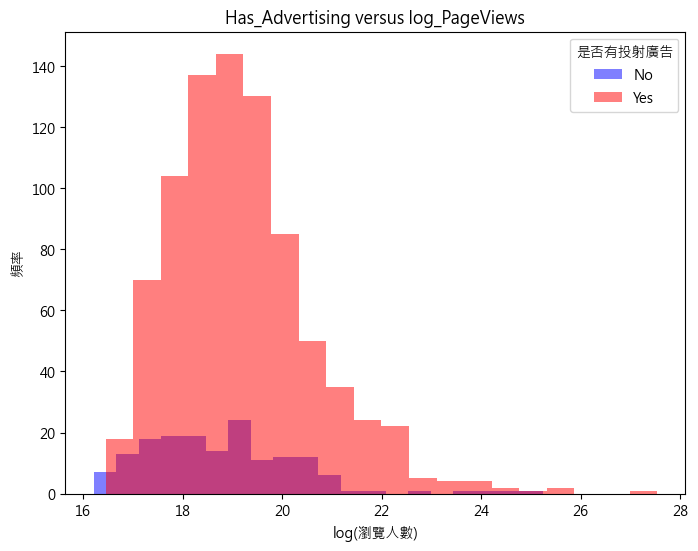

In [14]:
# strip blank space
file['Has_Advertising_stripped'] = file['Has_Advertising'].str.strip()
diff_count = (file['Has_Advertising'] != file['Has_Advertising_stripped']).sum()
if diff_count > 0:
    file['Has_Advertising'] = file['Has_Advertising_stripped']

# Nan
missing_count = file['Has_Advertising'].isna().sum()
print(f"Nan counts: {missing_count}")

plt.figure(figsize=(8, 6))
colors = {"No": 'blue', "Yes": 'red'}

for advertising_status, data in file.groupby('Has_Advertising'):
    print(f"Advertising Status: {advertising_status}, Data Size: {len(data)}")  # 輸出分組資訊
    plt.hist(data['log_PageViews'], bins=20, alpha=0.5, label=advertising_status, color=colors[advertising_status])

plt.xlabel('log(瀏覽人數)')
plt.ylabel('頻率')

plt.legend(title='是否有投射廣告')
plt.title("Has_Advertising versus log_PageViews")
plt.show()


InEnglish Unique Values: ['Yes' 'No' nan]
InEnglish
Yes    58
No     42
Name: count, dtype: int64


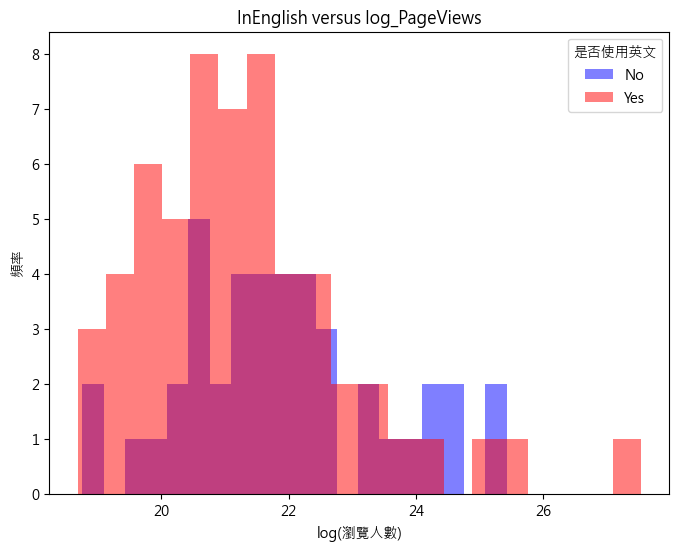

In [ ]:
# InEnglish unique()，avoid KeyError
print("InEnglish Unique Values:", file['InEnglish'].unique())
print(file['InEnglish'].value_counts())

plt.figure(figsize=(8, 6))
colors = {"No": 'blue', "Yes": 'red'}

for inEnglish_status, data in file.groupby('InEnglish'):
    plt.hist(data['log_PageViews'], bins=20, alpha=0.5, label=inEnglish_status, color=colors[inEnglish_status])

plt.xlabel('log(瀏覽人數)')
plt.ylabel('頻率')

plt.legend(title='是否使用英文')
plt.title("InEnglish versus log_PageViews")
plt.show()

#### **移除 InEnglish，缺失比例過高，保留價值低**

In [10]:
X = file[['Has_Advertising','log_UniqueVisitors']]
y = file['log_PageViews']

X_encoded = pd.get_dummies(X, drop_first=True)  # Binary transform（Yes=1, No=0）
X_has_advertising = X_encoded[['Has_Advertising_Yes']]

# === 基準模型：使用 DummyRegressor 只預測全體平均 ===
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_encoded, y)
y_pred_baseline = dummy_model.predict(X_encoded)

# === 分組模型：根據自變數來預測不同平均值 ===
linear_model = LinearRegression()
linear_model.fit(X_has_advertising, y)
y_pred_has_advertising = linear_model.predict(X_has_advertising)

# === RMSE ===
rmse_baseline = np.sqrt(mean_squared_error(y, y_pred_baseline))
rmse_has_advertising = np.sqrt(mean_squared_error(y, y_pred_has_advertising))

# === r2 ===
r2_baseline = r2_score(y, y_pred_baseline)
r2_has_advertising = r2_score(y, y_pred_has_advertising)

print(f"{'Baseline Model':-<20} log RMSE: {rmse_baseline:.5f} | r2: {r2_baseline:.5f}")
print(f"{'Has_Advertising':-<20} log RMSE: {rmse_has_advertising:.5f} | r2: {r2_has_advertising:.5f}")


Baseline Model------ log RMSE: 1.47538 | r2: 0.00000
Has_Advertising----- log RMSE: 1.46744 | r2: 0.01074


### **將 Has_Advertising 納入模型做預測**

- Has_Advertising 對 y 的影響很小，HasAdvertising 可能不是一個關鍵變數

In [30]:
X = file[['Has_Advertising','log_UniqueVisitors']]
y = file['log_PageViews']

# feature classification
numeric_features = ['log_UniqueVisitors']
categorical_features = ['Has_Advertising']

# feature transform
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# 整合數值和類別特徵，輸出統一的特徵矩陣
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2023)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# evaluation
print("y_test mean:", y_test.mean())
print("y_test std:", y_test.std())
print("\n")

# 5-folds
r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R^2 scores:", r2_scores)
print(f"Mean R^2: {r2_scores.mean():.5f}")
print(f"Std R^2: {r2_scores.std():.5f}")
print("\n")

mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)  # 轉為正值並開根號
print("Cross-validated RMSE scores:", rmse_scores)
print(f"Mean RMSE: {rmse_scores.mean():.5f}")
print(f"Std RMSE: {rmse_scores.std():.5f}")


y_test mean: 19.215886109020484
y_test std: 1.4266398362900836


Cross-validated R^2 scores: [ 0.44885595  0.03462633  0.01648876 -0.01943232  0.04860807]
Mean R^2: 0.10583
Std R^2: 0.17302


Cross-validated RMSE scores: [1.21930397 1.08226008 1.04399404 1.04155217 0.99923024]
Mean RMSE: 1.07727
Std RMSE: 0.07573


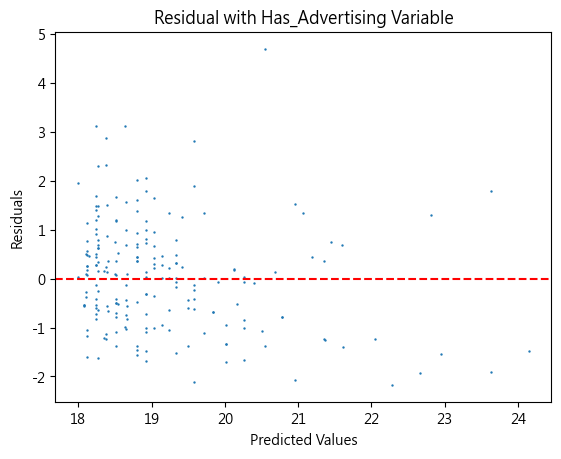

In [15]:
# residuals

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

residuals = y_test - y_pred
plt.scatter(y_pred, residuals, s=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual with Has_Advertising Variable")
plt.show()


### **加入 Category 作為變數考量**

In [13]:
# strip blank space
file['Category_stripped'] = file['Category'].str.strip()
diff_count = (file['Category'] != file['Category_stripped']).sum()
if diff_count > 0:
    file['Category'] = file['Category_stripped']

# Nan
missing_count = file['Category'].isna().sum()
print(f"空值數量: {missing_count}")

# value_counts
# print("Category Unique Values:", file['Category'].unique())
print("Category Unique Values Counts:",file['Category'].value_counts())


空值數量: 47
Category Unique Values Counts: Category
Web Portals           70
News                  29
Social Networks       27
Online Games          25
Newspapers            24
                      ..
Public Finance         1
Marketing Services     1
Simulation Games       1
Crafts                 1
Film & TV Industry     1
Name: count, Length: 230, dtype: int64


In [15]:
# 刪除 'Category' 欄位有空值的行，並且同步更新 'y' 的資料
file_cleaned = file.dropna(subset=['Category'])

# X_cleaned and y_cleaned
X_cleaned = file_cleaned[['Has_Advertising', 'log_UniqueVisitors', 'Category']]  # 或者根據實際選擇欄位
y_cleaned = file_cleaned['log_PageViews']

print(f"X_cleaned shape: {X_cleaned.shape}")
print(f"y_cleaned shape: {y_cleaned.shape}")


X_cleaned shape: (953, 3)
y_cleaned shape: (953,)


In [19]:
# One-Hot for 'Category'
X_encoded = pd.get_dummies(X_cleaned, drop_first=True)

# === 基準模型：使用 DummyRegressor 只預測全體平均 ===
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_encoded, y_cleaned)
y_pred_baseline = dummy_model.predict(X_encoded)

# === 分組模型：根據自變數來預測值 ===
# 計算 Category 分組平均值
category_means = file_cleaned.groupby('Category')['log_PageViews'].mean()
# 用每個類別的平均值作為預測值
y_pred_category = file_cleaned['Category'].map(category_means)

# === RMSE ===
rmse_baseline = np.sqrt(mean_squared_error(y_cleaned, y_pred_baseline))
rmse_category_grouped = np.sqrt(mean_squared_error(y_cleaned, y_pred_category))

# === r2 ===
r2_baseline = r2_score(y_cleaned, y_pred_baseline)
r2_category_grouped = r2_score(y_cleaned, y_pred_category)

print(f"{'Baseline Model':-<20} log RMSE: {rmse_baseline:.5f} | r2: {r2_baseline:.5f}")
print(f"{'Category':-<20} log RMSE: {rmse_category_grouped:.5f} | r2: {r2_category_grouped:.5f}")


Baseline Model------ log RMSE: 1.46896 | r2: 0.00000
Category------------ log RMSE: 1.14557 | r2: 0.39183


#### **小結論**

- 根據上述結果，**Category** 這個變數在預測 `log_PageViews` 時，顯然比基準模型更有效。基準模型只是預測整體的平均值，沒有考慮到具體的變數，而分組模型能根據不同的 `Category` 類別來預測，這提高了模型的預測精度。

- **R² 值的提升**（從 0 到 0.392）表明，`Category` 變數在一定程度上能夠解釋目標變數的變化，對模型效果有顯著的貢獻。


### **將 Category 納入模型**

In [38]:
X = file_cleaned[['Has_Advertising', 'log_UniqueVisitors', 'Category']]  # 特徵
y = file_cleaned['log_PageViews']  # 目標變數

# feature classification
numeric_features = ['log_UniqueVisitors']
categorical_features = ['Has_Advertising', 'Category']

# feature transform
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 確保 OneHotEncoder 不輸出 sparse matrix
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# 整合數值和類別特徵，輸出統一的特徵矩陣
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2023)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# evaluation
print("y_test mean:", y_test.mean())
print("y_test std:", y_test.std())
print("\n")

# 5-folds
r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R^2 scores:", r2_scores)
print(f"Mean R^2: {r2_scores.mean():.5f}")
print(f"Std R^2: {r2_scores.std():.5f}")
print("\n")

mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)  # 轉為正值並開根號
print("Cross-validated RMSE scores:", rmse_scores)
print(f"Mean RMSE: {rmse_scores.mean():.5f}")
print(f"Std RMSE: {rmse_scores.std():.5f}")


y_test mean: 19.190222406748585
y_test std: 1.476795459141584


Cross-validated R^2 scores: [-3.99744385e+21 -7.49207491e+22 -1.86777143e+23 -1.74937339e+23
 -1.87513548e+21]
Mean R^2: -88501562012324149067776.00000
Std R^2: 79948427806727133462528.00000


Cross-validated RMSE scores: [1.03073311e+11 2.92970197e+11 4.47779488e+11 4.23032061e+11
 4.36192399e+10]
Mean RMSE: 262094859446.98373
Std RMSE: 163922115678.52905


#### **直接做的話模型失控，採用 L2 正歸化**

- Category 類別過多，導致 One-Hot Encoding 產生過多維度，導致回歸係數失控，使 RMSE 和 R² 變成異常值。
- 交叉驗證時可能有變數出現在部分 fold 內但不在其他 fold 內，導致 LinearRegression 無法處理。

In [39]:
X = file_cleaned[['Has_Advertising', 'log_UniqueVisitors', 'Category']]
y = file_cleaned['log_PageViews']

# feature classification
numeric_features = ['log_UniqueVisitors']
categorical_features = ['Has_Advertising', 'Category']

# feature transform
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 確保 OneHotEncoder 不輸出 sparse matrix
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# 整合數值和類別特徵，輸出統一的特徵矩陣
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2023)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluation
print("y_test mean:", y_test.mean())
print("y_test std:", y_test.std())
print("\n")

# 5-folds
r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R^2 scores:", r2_scores)
print(f"Mean R^2: {r2_scores.mean():.5f}")
print(f"Std R^2: {r2_scores.std():.5f}")
print("\n")

mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-mse_scores)  # 轉為正值並開根號
print("Cross-validated RMSE scores:", rmse_scores)
print(f"Mean RMSE: {rmse_scores.mean():.5f}")
print(f"Std RMSE: {rmse_scores.std():.5f}")


y_test mean: 19.190222406748585
y_test std: 1.476795459141584


Cross-validated R^2 scores: [0.58500809 0.24756549 0.14274184 0.13775658 0.25313464]
Mean R^2: 0.27324
Std R^2: 0.16349


Cross-validated RMSE scores: [1.05020687 0.9284462  0.95930817 0.93917597 0.87052837]
Mean RMSE: 0.94953
Std RMSE: 0.05835


### **總結**

- 從一開始只將`log_UniqueVisitors`作為預測時 `R^2 = 0.98`、`RMSE = 1.081`；接著再將`Has_Advertising`納入模型時 `R^2 = 1.0`、`RMSE = 1.07`；最後把`Category`納入後`R^2 = 0.273`、`RMSE = 0.95`，有明顯進步，誤差下降，預測準確度提高，表示模型學到了部分資訊，但還有進步空間。

| 納入變數                 | R²   | RMSE  | 變化趨勢                      |
|--------------------------|------|------|-----------------------------|
| 只使用 `log_UniqueVisitors` | 0.098 | 1.081 | 初始模型基準                 |
| 加入 `Has_Advertising`   | 0.100 | 1.070 | `R²` 提升，`RMSE` 略微下降     |
| 加入 `Category`          | 0.273 | 0.950 | `R²` 顯著提升，誤差明顯下降   |

**可能的問題**
- `R^2` 變異性較大（最高 `0.585`，最低 `0.138`），表示不同數據區間的擬合效果差異大。
